# Preprocess Interferon Data

Data downloded from the demuxlet paper. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
import time

In [3]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'


### Create AnnData object and attach the metadata for interferon dataset

This dataset was used for the demuxlet paper, https://www.nature.com/articles/nbt.4042

In [ ]:
metadata = pd.read_csv(data_path + 'GSE96583_batch2.total.tsne.df.tsv', sep='\t')

In [ ]:
ctrl_adata = sc.read_10x_mtx(data_path + 'ctrl_mtx/')
stim_adata = sc.read_10x_mtx(data_path + 'stim_mtx/')

In [ ]:
both_barcodes = list(set(ctrl_adata.obs.index) & set(stim_adata.obs.index))
stim_adata.obs.index = [bc + '1' if bc in both_barcodes else bc for bc in stim_adata.obs.index.tolist()]

In [ ]:
combined_X = sp.sparse.vstack([ctrl_adata.X, stim_adata.X])
combined_bc = ctrl_adata.obs.index.tolist() + stim_adata.obs.index.tolist()

In [ ]:
adata = sc.AnnData(combined_X)
adata.obs.index = combined_bc
adata.var = ctrl_adata.var
adata.obs = adata.obs.join(metadata, how='left')
adata.obs['ind'] = adata.obs['ind'].astype('category')
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obsm['X_tsne'] = adata.obs[['tsne1', 'tsne2']].values
adata.write(data_path + 'interferon.h5ad')

### Read the AnnData

In [77]:
adata = sc.read(data_path + 'interferon.h5ad')

/anaconda3/envs/sc_ht/lib/python3.7/site-packages/anndata/readwrite/read.py:440: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,


In [79]:
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

In [80]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

### Basic filtering

In [82]:
sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)

### Compute QC metrics

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


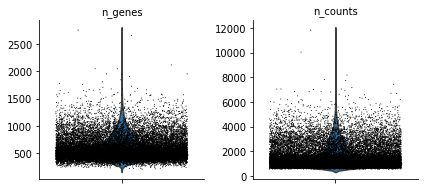

In [69]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

/anaconda3/envs/sc_ht/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


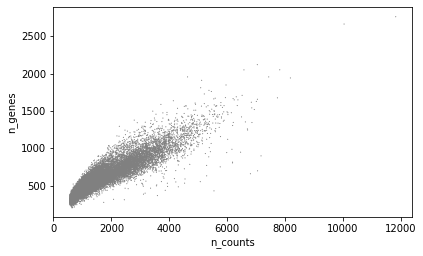

In [70]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')


### Normalize per cell

In [83]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)


In [84]:
sc.pp.log1p(adata)


### Highly variable genes

In [107]:
sc.pp.highly_variable_genes(adata, min_mean=0.2, max_mean=3, min_disp=0.05)


In [113]:
adata = adata[:, adata.var['highly_variable']]


In [115]:
sc.pp.regress_out(adata, ['n_counts'])


... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


In [116]:
sc.pp.scale(adata, max_value=10)

### Save normalized AnnData

In [117]:
adata.shape

(24562, 1884)

In [118]:
sc.write(data_path + 'interferon.norm.h5ad', adata)

### Create a gene filtered raw counts AnnData

In [119]:
gene_list = adata.var.index.tolist()
adata_raw = sc.read(data_path + 'interferon.h5ad')
adata_raw = adata_raw[(adata_raw.obs.multiplets == 'singlet') & (adata_raw.obs.cell != 'nan'), :].copy()

/anaconda3/envs/sc_ht/lib/python3.7/site-packages/anndata/readwrite/read.py:440: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,


In [120]:
sc.pp.filter_cells(adata_raw, min_genes=200)
sc.pp.filter_genes(adata_raw, min_cells=3)

In [121]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(axis=1).A1
adata_raw = adata_raw[adata_raw.obs['n_genes'] < 2500,:]
adata_raw = adata_raw[:, gene_list]

In [122]:
sc.write(data_path + 'interferon.raw.h5ad', adata_raw)

Trying to set attribute `.obs` of view, making a copy.
... storing 'ind' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cluster' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'multiplets' as categorical


### Pseudotime in CD4+ T cells

In [119]:
adata_raw = sc.read(data_path + 'interferon.raw.h5ad')


In [120]:
cd4_adata = adata_raw[adata_raw.obs['cell'] == 'CD4 T cells'].copy()

In [121]:
sc.pp.normalize_per_cell(cd4_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cd4_adata)
sc.pp.regress_out(cd4_adata, ['n_counts'])
sc.pp.scale(cd4_adata, max_value=10)

In [162]:
sc.pp.neighbors(cd4_adata, n_neighbors=500, method='umap')

In [163]:
sc.tl.pca(cd4_adata)
sc.tl.umap(cd4_adata)

In [164]:
ctrl_idx = (cd4_adata.obs['stim'] == 'ctrl').values
stim_idx = (cd4_adata.obs['stim'] == 'stim').values

In [165]:
stim_to_ctrl_mat = cd4_adata.uns['neighbors']['connectivities'].toarray()[stim_idx, :][:, ctrl_idx]

In [166]:
num_ctrl_neighbors = stim_to_ctrl_mat.max(axis=1)

In [167]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [168]:
connectivity = np.ones(cd4_adata.shape[0])
connectivity[stim_idx] = num_ctrl_neighbors
cd4_adata.obs['ctrl_connectivity'] = connectivity

In [169]:
stim_tp_cutoffs = histedges_equalN(num_ctrl_neighbors, 5)
cd4_adata.obs['stim_tp'] = \
    [5-np.where(stim_tp_cutoffs >= connectivity[i])[0][0] for i in range(connectivity.shape[0])]

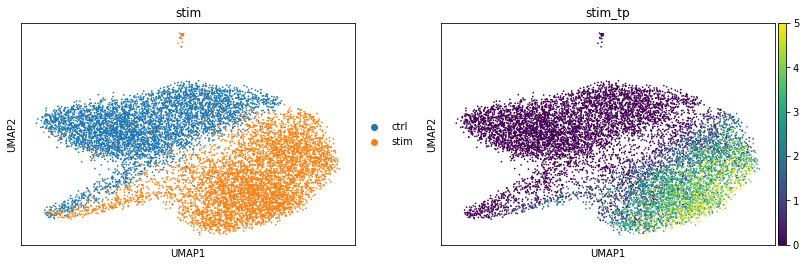

In [170]:
sc.pl.umap(cd4_adata, color=['stim', 'stim_tp'])

In [172]:
cd4_adata.obs.query('stim == "stim"').stim_tp.value_counts()

3    1044
2    1044
1    1044
0    1043
4     763
5     281
Name: stim_tp, dtype: int64

In [175]:
cd4_adata.obs.to_csv(data_path + 'cd4_timepoints.csv')